In [1]:
#NO NEED TO HYPERPARAMETER TUNE
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
imputed_data = pd.read_csv("imputed_data_handle_multicollinearity.csv")
imputed_data=imputed_data.drop('Unnamed: 0',axis=1)
imputed_data.head()

,GrLivArea,SalePrice,OverallQual,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_Unknown,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y
0,1049.0,139500.0,5.0,1984.0,1984.0,552.0,393.0,104.0,1049.0,1049.0,...,0,0,0,1,0,0,0,0,1,1
1,1049.0,139500.0,5.0,1984.0,1984.0,552.0,393.0,104.0,1049.0,1049.0,...,0,0,0,1,0,0,0,0,0,1
2,1049.0,139500.0,5.0,1984.0,1984.0,552.0,393.0,104.0,1049.0,1049.0,...,0,0,0,1,0,0,0,0,1,1
3,1001.0,124900.0,5.0,1930.0,2007.0,737.0,0.0,100.0,837.0,1001.0,...,0,0,0,0,0,0,0,0,1,1
4,1001.0,124900.0,5.0,1930.0,2007.0,737.0,0.0,100.0,837.0,1001.0,...,0,0,0,1,0,0,0,0,0,1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [10:05<00:00, 12.11s/it]


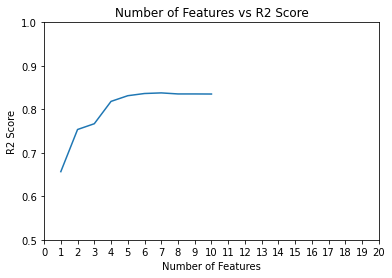

In [3]:
# separate the independent variables (features) from the dependent variable (target)
X = imputed_data.drop('SalePrice', axis=1)
y = imputed_data['SalePrice']

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# initialize empty lists to store R2, feature names and number of features
train_r2_scores = []
test_r2_scores = []
feat_names = []
num_features = []

# select the best feature to start
best_feature = None
best_train_r2 = -np.inf
prev_best_train_r2 = -np.inf

# set up KFold with shuffle=True
kf = KFold(n_splits=5, shuffle=True)

# loop through the number of features with a progress bar
for i in tqdm(range(min(X.shape[1], 50))):
    if len(num_features) == 20:
        break
    best_feature_idx = -1
    for j in range(X.shape[1]):
        if j not in num_features:
            features = num_features + [j]
            # select the features
            X_train_selected = X_train.iloc[:, features]
            X_test_selected = X_test.iloc[:, features]
            # select the model
            model = Lasso()
            # fit the model and calculate R2 using cross-validation
            train_r2_scores_fold = []
            for train_index, val_index in kf.split(X_train_selected, y_train):
                X_train_fold, X_val_fold = X_train_selected.iloc[train_index], X_train_selected.iloc[val_index]
                y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                model.fit(X_train_fold, y_train_fold)
                train_r2_scores_fold.append(model.score(X_val_fold, y_val_fold))
            train_r2 = np.mean(train_r2_scores_fold)
            model.fit(X_train_selected, y_train)
            test_r2 = model.score(X_test_selected, y_test)
            # check if this is the best feature so far
            if train_r2 > best_train_r2:
                best_train_r2 = train_r2
                best_feature_idx = j
                best_test_r2 = test_r2
    if best_feature_idx not in num_features and len(num_features) <= 20:
        num_features.append(best_feature_idx)
        feat_names.append(X.columns[best_feature_idx])
        train_r2_scores.append(best_train_r2)
        test_r2_scores.append(best_test_r2)
        prev_best_train_r2 = best_train_r2

# create a dataframe to store the results
if len(train_r2_scores) == len(test_r2_scores) == len(num_features) == len(feat_names):
    results_df = pd.DataFrame({'train_r2': train_r2_scores, 'test_r2': test_r2_scores, 'num_features': np.arange(1, len(num_features)+1), 'feature_name': feat_names})
else:
    print("Error: train_r2_scores, test_r2_scores, num_features and/or feat_names have different lengths.")
    print("train_r2_scores:", train_r2_scores)
    print("test_r2_scores:", test_r2_scores)
    print("num_features:", num_features)
    print("feat_names:", feat_names)
    
# plot the results
plt.plot(results_df['num_features'], results_df['test_r2'])
plt.xlabel('Number of Features')
plt.ylabel('R2 Score')
plt.title('Number of Features vs R2 Score')
plt.ylim(0.5, 1)
plt.xlim(1,20)
plt.xticks(range(0,21,1))
plt.show()

In [4]:
# Define the model name
model_name = 'Lasso'

# Sort the features by importance
results_df = results_df.sort_values(by='test_r2', ascending=True).reset_index(drop=True)

# Add index to indicate feature importance
results_df['importance_rank'] = results_df.index + 1

# Add model name
results_df['model_name'] = model_name

# Print the ranked feature list with model name
print(results_df[['importance_rank', 'feature_name', 'test_r2', 'model_name']])

   importance_rank       feature_name   test_r2 model_name
0                1        OverallQual  0.656698      Lasso
1                2           1stFlrSF  0.753635      Lasso
2                3         BsmtFinSF1  0.766918      Lasso
3                4          GrLivArea  0.818269      Lasso
4                5         GarageArea  0.831328      Lasso
5                6  HouseStyle_1.5Unf  0.835211      Lasso
6                7         Fireplaces  0.835388      Lasso
7                8       CentralAir_Y  0.835388      Lasso
8                9       YearRemodAdd  0.836400      Lasso
9               10        GarageYrBlt  0.837804      Lasso


In [5]:
results_df.to_csv('results_lasso.csv', index=False)